In [3]:
import sys
sys.path.append(r'D:\github\ripple_heterogeneity\python')
import functions,loading

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import importlib
import glob
import os
import pickle
import replay_fig
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random
import itertools
from scipy import stats


In [10]:
# df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
# df.basepath.unique()

In [11]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
df = df[df.basepath.str.contains('GrosmarkAD')]
df
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_test'
# replay_run.main(df,save_path,parallel=True)

,Var1,basepath,basename
97,97,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,Achilles_10252013
98,98,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013,Achilles_11012013
99,99,Z:\Data\GrosmarkAD\Buddy\Buddy_06272013,Buddy_06272013
100,100,Z:\Data\GrosmarkAD\Cicero\Cicero_09012014,Cicero_09012014
101,101,Z:\Data\GrosmarkAD\Cicero\Cicero_09102014,Cicero_09102014
102,102,Z:\Data\GrosmarkAD\Cicero\Cicero_09172014,Cicero_09172014
103,103,Z:\Data\GrosmarkAD\Gatsby\Gatsby_08022013,Gatsby_08022013
104,104,Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013,Gatsby_08282013


In [17]:
def pairwise_corr(unit_mat):
    x = np.arange(0,unit_mat.shape[0])
    c = np.array(list(itertools.combinations(x, 2)))
    rho = []
    pval = []
    for i,s in enumerate(c):	
        rho_, pval_ = stats.spearmanr(unit_mat[s[0],:], unit_mat[s[1],:])
        rho.append(rho_)
        pval.append(pval_)
    return rho,pval,c

importlib.reload(functions)
basepath = df.basepath.unique()[0]

cell_metrics,data,ripples,fs_dat = loading.load_basic_data(basepath)

restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")) &
                    (cell_metrics.bad_unit == False))  
                    
# restrict cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
st_unit_rip = st_unit[ripple_epochs]

spk_count_rip = functions.get_participation(st_unit.data,ripples.start.values,ripples.stop.values,par_type='counts')

rho,pval,c = pairwise_corr(spk_count_rip)

temp_df = pd.DataFrame()
temp_df['ref'] = c[:,0]
temp_df['target'] = c[:,1]
temp_df['UID_ref'] = cell_metrics.UID.iloc[temp_df['ref']].values
temp_df['UID_target'] = cell_metrics.UID.iloc[temp_df['target']].values
temp_df['rho'] = rho
temp_df['pval'] = pval
temp_df['deepSuperficial_ref'] = cell_metrics.deepSuperficial.iloc[temp_df['ref']].values
temp_df['deepSuperficial_target'] = cell_metrics.deepSuperficial.iloc[temp_df['target']].values
temp_df['basepath'] = basepath

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [13]:
temp_df

,ref,target,UID_ref,UID_target,rho,pval,deepSuperficial_ref,deepSuperficial_target,basepath
0,0,1,1,3,0.029471,1.755862e-03,Deep,Superficial,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
1,0,2,1,4,0.028926,2.134949e-03,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
2,0,3,1,5,-0.001878,8.419785e-01,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
3,0,4,1,7,-0.003942,6.756905e-01,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
4,0,5,1,9,-0.030480,1.212511e-03,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
...,...,...,...,...,...,...,...,...,...
28915,237,239,272,274,0.022569,1.658589e-02,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
28916,237,240,272,275,0.029005,2.075299e-03,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
28917,238,239,273,274,0.150396,5.333362e-58,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
28918,238,240,273,275,0.004501,6.328206e-01,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013


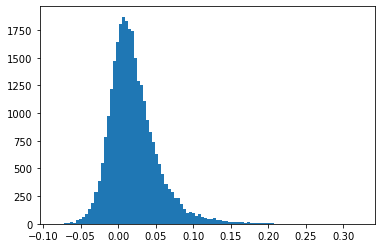

In [16]:
plt.hist(temp_df.rho,100)
plt.show()

In [ ]:
def SVCA(Ff, npc, ntrain, ntest, itrain, itest):
    """
    % computes a cross-validated form of PCA: Shared Variance Component
    % Analysis. Components are extracted from the covariance between neuron
    % sets "ntrain" and "ntest" on training timepts "itrain". The variance of
    % these covariance components is computed on testing timepts "itest". 
    % This variance is the amount of reliable variance of that component 
    % (because it's consistent across timepts). 
    % Why compute it in the covariance space?
    %   we assume the covariance btw/ neurons is consistent across time 
    %   - we have no other metric to track because we are not presenting stimuli
    % INPUTS:
    %     Ff (neurons x timepts)
    %     npc (number of PCs to compute)
    %     ntrain (one half of neurons)
    %     ntest (other half of neurons)
    %     itrain (one half of timepts)
    %     itest (other half of timepts)
    % OUTPUTS:
    %     sneur (shared variance of each covariance component)
    %     vneur (total variance of each covariance component)
    %     u (left eigenvectors of covariance matrix btw ntrain and ntest on
    %        itrain timepts)
    %     v (right eigenvectors of covariance matrix btw ntrain and ntest on
    %        itrain timepts)
    """
    cov = Ff[ntrain,itrain] * Ff[ntest,itrain].T
    u,s,v = np.linalg.svd(cov)
    u = u[:,0:npc]
    v = v[:,0:npc]
    s1 = u.T * Ff[ntrain,itest]
    s2 = v.T * Ff[ntest,itest]
    sneur = np.sum(s1 * s2, axis=1)
    varneur = np.sum(s1**2 + s2**2,axis=1) / 2
    return sneur, varneur, u, v